# CPV Statistik

Dieses Notebook enthält diverese Queries zu CPV Codes und zugehörigen Ausschreibungen

In [2]:
%matplotlib inline

import matplotlib

import pandas as pd

import numpy as np

from db import engine

# CPV Queries for each cpv part

In [3]:
cpv_parts = {
    'division': 2,
    'group': 3,
    'class': 4,
    'category': 5
}

In [4]:
# for each cpv_parts

cpv_stats = {}
for cpv_part, cpv_digit in cpv_parts.items():
    cpv_stats[cpv_part] = pd.read_sql("""
        SELECT
            count,
            cpv_division,
            money,
            cpv.cpv_englisch as label
        FROM (
            SELECT 
                CONCAT(SUBSTRING(cpv_dokument.cpv_nummer,1,{}),'{}') as cpv_division,
                count(zuschlag.meldungsnummer) as count,
                SUM(zuschlag.preis) as money
            FROM cpv_dokument
            JOIN zuschlag ON cpv_dokument.meldungsnummer = zuschlag.meldungsnummer 
            GROUP BY SUBSTRING(cpv_dokument.cpv_nummer,1,{})
        ) cpv_and_count
        JOIN cpv ON cpv_and_count.cpv_division = cpv.cpv_nummer
    """.format(cpv_digit, '000000'[:8-cpv_digit], cpv_digit),
    engine)

In [5]:
# for full cpv
cpv_stats['full'] = pd.read_sql(
"""
SELECT 
    cpv_dokument.cpv_nummer as cpv,
    count(cpv_dokument.meldungsnummer) as count,
    cpv.cpv_englisch as label,
    SUM(zuschlag.preis) as money 
FROM cpv_dokument
JOIN cpv ON cpv.cpv_nummer = cpv_dokument.cpv_nummer
JOIN zuschlag ON cpv_dokument.meldungsnummer = zuschlag.meldungsnummer 
GROUP BY cpv_dokument.cpv_nummer;
""",
engine)

In [6]:
def shortenName(entry):
    num_of_chars = 20
    return entry[:num_of_chars] + '...' if len(entry) > num_of_chars else entry
# Shorten labels
for cpv_part, cpv_digit in cpv_parts.items():
    cpv_stats[cpv_part]['label'] = cpv_stats[cpv_part]['label'].apply(shortenName)

# Zuschlag per Division

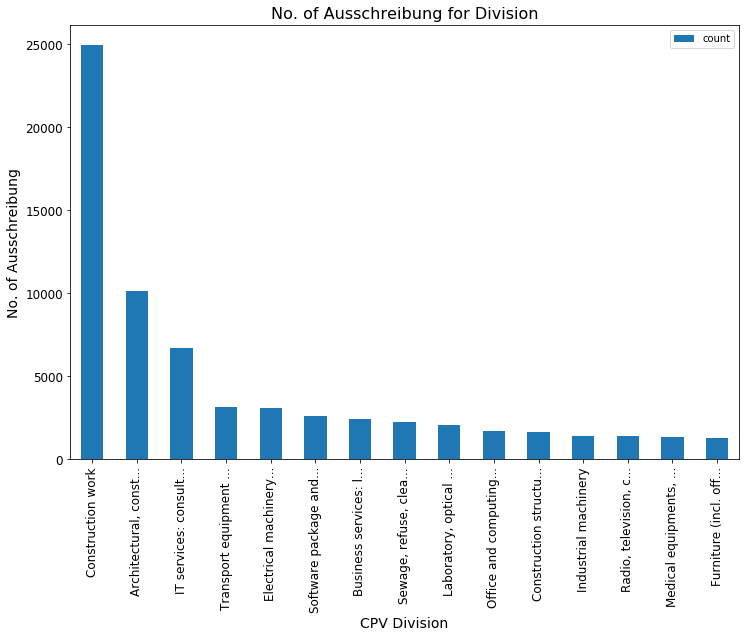

In [7]:
ax = cpv_stats['division'].sort_values('count', ascending=False).head(15).plot.bar(y='count', x='label', title='No. of Ausschreibung for division', figsize=(12, 8), fontsize=12)
ax.set_title("No. of Ausschreibung for Division", fontsize=16)
ax.set_ylabel("No. of Ausschreibung", fontsize=14)
ax.set_xlabel("CPV Division", fontsize=14)
ax

In [19]:
pd.options.display.float_format = '{:,.0f}'.format

for key, cpv_stat in cpv_stats.items():
    print('=================================')
    print(key)
    print('---------------------------------')
    print(cpv_stat.describe())

division
---------------------------------
       count          money
count     43             43
mean   1,771  4,440,946,790
std    4,065 11,406,219,541
min       44     19,493,283
25%      192    242,490,676
50%      472    917,440,517
75%    1,528  3,263,277,738
max   24,922 67,319,212,154
group
---------------------------------
       count          money
count    282            272
mean     270    701,957,578
std      981  2,978,610,973
min        1          2,200
25%       16     14,912,755
50%       56     74,787,202
75%      160    300,556,125
max   11,016 31,417,663,207
class
---------------------------------
       count          money
count    913            868
mean      83    219,676,220
std      418  1,310,505,395
min        1              0
25%        4      2,806,523
50%       14     14,894,804
75%       47     75,510,440
max    9,361 28,119,326,913
category
---------------------------------
       count          money
count  2,019          1,882
mean      38    101,38

In [17]:
cpv_stat.describe()

,cpv,count,money
count,"3,875","3,875","3,547"
mean,"46,872,921",20,"54,487,894"
std,"19,330,014",177,"594,695,474"
min,"3,000,000",1,0
25%,"34,114,115",2,"1,040,283"
50%,"44,212,200",4,"4,288,131"
75%,"51,172,500",12,"18,036,797"
max,"98,395,000","9,361","28,119,326,913"


In [35]:
median_cpv_per_part = pd.DataFrame([cpv_stat.median()['count'] for cpv_stat in cpv_stats.values()], index=cpv_stats.keys(), columns=['count'])
median_cpv_per_part.rename({'count':'Number of Ausschreibung for CPV Part'}, axis=1)

,Number of Ausschreibung for CPV Part
division,472.0
group,56.5
class,14.0
category,7.0
full,4.0


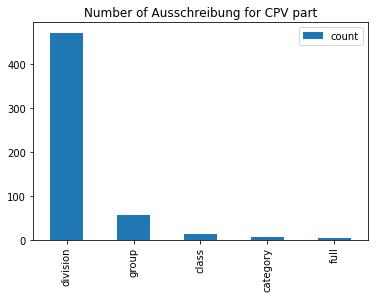

In [36]:
median_cpv_per_part.plot.bar(y='count', title='Number of Ausschreibung for CPV part')

# Compare cpv distribution

Text(0, 0.5, 'Anzahl CPV-Codes')

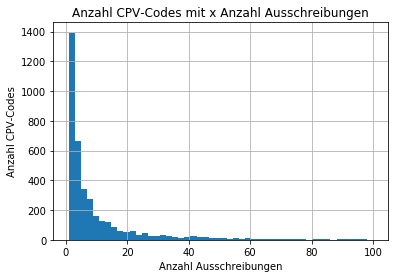

In [37]:
df = cpv_stats['full']
df[df['count'].between(0,100)].sort_values('count', ascending=False).hist('count', bins=50)
matplotlib.pyplot.title("Anzahl CPV-Codes mit x Anzahl Ausschreibungen")
matplotlib.pyplot.xlabel("Anzahl Ausschreibungen")
matplotlib.pyplot.ylabel("Anzahl CPV-Codes")

Text(0, 0.5, 'Anzahl CPV-Codes')

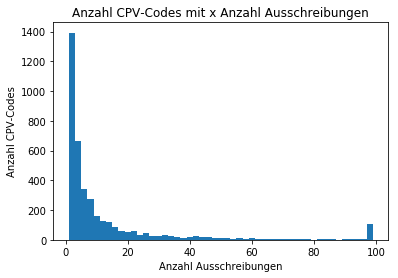

In [38]:
bins = np.arange(1,100,2)
matplotlib.pyplot.hist(np.clip(df['count'], bins[0], bins[-1]), bins=bins)
matplotlib.pyplot.title("Anzahl CPV-Codes mit x Anzahl Ausschreibungen")
matplotlib.pyplot.xlabel("Anzahl Ausschreibungen")
matplotlib.pyplot.ylabel("Anzahl CPV-Codes")

In [39]:
df['count'].describe()

count    3875.000000
mean       19.790968
std       176.806649
min         1.000000
25%         2.000000
50%         4.000000
75%        12.000000
max      9361.000000
Name: count, dtype: float64

In [40]:
{
    'small': df[df['count']<=3].size,
    'all': df.size,
    'small_relative': df[df['count']<=2].size / df.size * 100
}

{'small': 7008, 'all': 15500, 'small_relative': 35.92258064516129}

In [41]:
df[ (df['count'] <=3) & (df.cpv % 100 != 0)].size

1812

In [42]:
#df[ (df['count'] <=3) & (df.cpv % 10 != 0)].sort_values('money')

In [43]:
null_df = pd.read_sql("select count(cpv_dokument.cpv_nummer), sum(zuschlag.preis) from cpv_dokument JOIN cpv ON cpv.cpv_nummer = cpv_dokument.cpv_nummer JOIN zuschlag ON cpv_dokument.meldungsnummer = zuschlag.meldungsnummer where cpv.cpv_deutsch != 'NULL';",
    engine)
not_null_df = pd.read_sql("select count(cpv_dokument.cpv_nummer), sum(zuschlag.preis) from cpv_dokument LEFT JOIN cpv ON cpv.cpv_nummer = cpv_dokument.cpv_nummer JOIN zuschlag ON cpv_dokument.meldungsnummer = zuschlag.meldungsnummer;",
    engine)
not_null_df

,count(cpv_dokument.cpv_nummer),sum(zuschlag.preis)
0,76698,1.932701e+11


In [21]:
df_unused_groups = pd.read_sql("select cpv_nummer, cpv_deutsch from cpv where cpv_nummer not in (select cpv_nummer from cpv_dokument) and cpv_nummer like '%%00000';",
            engine)
df_used_groups = pd.read_sql("select cpv_nummer, cpv_deutsch from cpv where cpv_nummer in (select cpv_nummer from cpv_dokument) and cpv_nummer like '%%00000';",
            engine)
df_unnec_cpvs.head(10)

,cpv_nummer,cpv_deutsch
0,3200000,"Getreide, Kartoffeln/Erdäpfel, Gemüse und Obst"
1,3300000,"Landwirtschafts-, Jagd- und Fischereierzeugnisse"
2,14200000,Sand und Ton
3,14300000,Chemische Mineralien und Düngemittelmineralien
4,14500000,In Bergwerken und Steinbrüchen gewonnene Erzeu...
5,14600000,Metallerze und Legierungen
6,14800000,Diverse nichtmetallische Mineralprodukte
7,16300000,Erntemaschinen
8,16400000,Bespritzungsmaschinen für Landwirtschaft oder ...
9,18500000,"Schmuck, Uhren und zugehörige Artikel"


In [26]:
print("unused groups: %s" % len(df_unused_groups))
print("used groups:   %s" % len(df_used_groups))
print("percentage:    %s%%" % str(len(df_unused_groups) / (len(df_unused_groups)+len(df_used_groups)) * 100))

unused groups: 48
used groups:   269
percentage:    15.141955835962145%


In [59]:
abteilungen = pd.read_sql("select count(*) from cpv where cpv_nummer like '%%000000';", engine)
gruppen = pd.read_sql("select count(*) from cpv where cpv_nummer like '%%00000'", engine)
klassen = pd.read_sql("select count(*) from cpv where cpv_nummer like '%%0000' and cpv_nummer not like '%%000000' and cpv_nummer not like '%%00000';", engine)
kategorien = pd.read_sql("select count(*) from cpv where cpv_nummer not like '%%000000' and cpv_nummer not like '%%00000' and cpv_nummer not like '%%0000';", engine)
[ abteilungen, gruppen, klassen, kategorien ]

[   count(*)
 0        45,    count(*)
 0       317,    count(*)
 0      1002,    count(*)
 0      8135]

In [46]:
import math

def calculate_cpv_cat(whatever):
    k=1
    while whatever['cpv'] % math.pow(10,k) == 0:
        k+=1
    return k

df['cpv_hierarchy'] = df.apply( calculate_cpv_cat, axis=1)
df2['cpv_hierarchy'] = df2.apply( calculate_cpv_cat, axis=1)
df

NameError: name 'df2' is not defined

In [47]:
df_filtered = df.drop([2478,2466,2318,2231,3546,3334,2230,3315,3463,2815,3316])
df_filtered.groupby('cpv_hierarchy')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
cpv_hierarchy,,,,,,,,
1,259.0,9.389961,18.103879,1.0,2.00,4.0,8.50,178.0
2,610.0,9.459016,23.657222,1.0,1.00,3.0,8.00,318.0
3,1127.0,10.976930,26.745418,1.0,2.00,3.0,10.00,436.0
4,1041.0,11.921230,25.667016,1.0,2.00,4.0,11.00,375.0
5,574.0,23.862369,121.781684,1.0,2.00,6.0,15.75,2111.0
6,209.0,54.779904,242.065013,1.0,4.00,12.0,44.00,3362.0
7,38.0,465.078947,1562.931694,4.0,23.00,58.5,146.25,9361.0
8,6.0,117.166667,52.795517,59.0,76.75,113.5,148.00,193.0


Text(0, 0.5, 'Anzahl CPV-Codes')

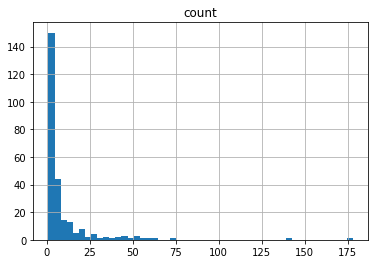

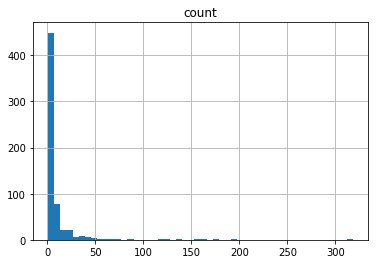

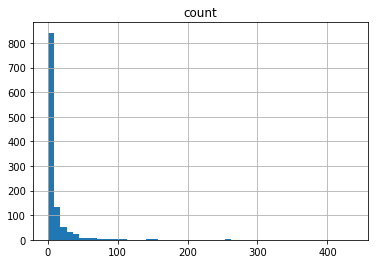

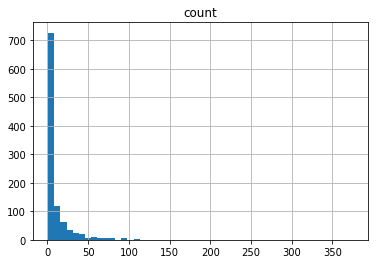

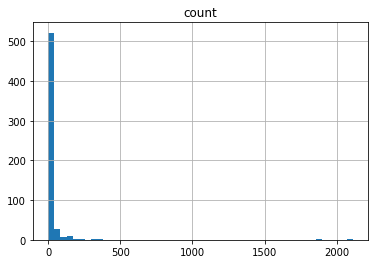

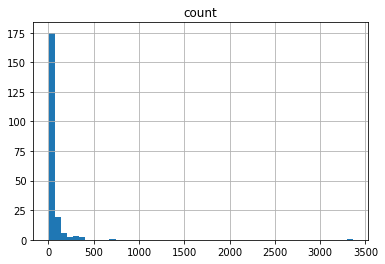

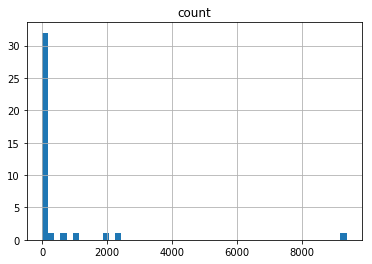

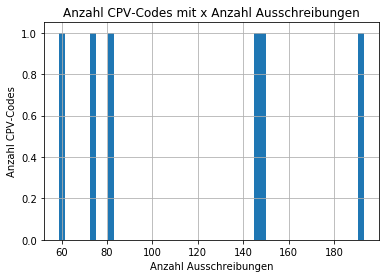

In [48]:
df_filtered.groupby('cpv_hierarchy').hist('count', bins=50)
matplotlib.pyplot.title("Anzahl CPV-Codes mit x Anzahl Ausschreibungen")
matplotlib.pyplot.xlabel("Anzahl Ausschreibungen")
matplotlib.pyplot.ylabel("Anzahl CPV-Codes")

In [19]:
df_filtered.groupby('cpv_hierarchy').apply(lambda x: x.sort_values('count', ascending=False).head(5) )

cpv  count  \
cpv_hierarchy                         
1             2735  45233141    377   
              2596  45215212    253   
              2736  45233142    203   
              2597  45215213    199   
              2507  45212222    166   
2             2723  45233120    931   
              2572  45214210    623   
              2646  45221250    462   
              2994  45331210    439   
              2573  45214220    421   
3             2571  45214200   1251   
              2947  45311200    647   
              2588  45215100    619   
              2679  45231300    530   
              4363  90911200    479   
4             3743  71541000    711   
              2569  45214000    662   
              2647  45222000    640   
              2945  45311000    629   
              2990  45331000    522   
5             2480  45210000   4898   
              3853  72260000   2408   
              764   31720000    679   
              3623  71240000    606   
              3942  75130000    552   
6             3634  71300000   6050   
              2479  45200000   2302   
              3614  71200000    799   
              4423  98300000    694   
              622   31200000    567   
7             2432  45000000  28538   
              3613  71000000   4544   
              3767  72000000   3295   
              3083  48000000   1713   
              1469  38000000    968   
8             4243  90000000    437   
              3432  60000000    290   
              3218  50000000    228   
              412   30000000    162   
              4166  80000000    155   

                                                                label  \
cpv_hierarchy                                                           
1             2735                     Straßeninstandhaltungsarbeiten   
              2596                               Bau von Altersheimen   
              2736                       Straßenausbesserungsarbeiten   
              2597                               Bau von Pflegeheimen   
              2507                                 Bau von Turnhallen   
2             2723                                 Straßenbauarbeiten   
              2572                               Bau von Grundschulen   
              2646  Tiefbauarbeiten, außer Tunneln, Schächten und ...   
              2994                   Installation von Lüftungsanlagen   
              2573                    Bau von weiterführenden Schulen   
3             2571                       Bauarbeiten für Schulgebäude   
              2947                       Elektroinstallationsarbeiten   
              2588        Bauarbeiten für Gebäude im Gesundheitswesen   
              2679  Bauarbeiten für Wasser- und Abwasserrohrleitungen   
              4363                                   Gebäudereinigung   
4             3743                      Projektmanagement im Bauwesen   
              2569   Bauarbeiten für Schulen oder Forschungsanstalten   
              2647  Oberbauarbeiten, außer Brücken, Tunneln, Schäc...   
              2945                    Installation von Elektroanlagen   
              2990  Installation von Heizungs-, Lüftungs- und Klim...   
5             2480                           Bauleistungen im Hochbau   
              3853        Dienstleistungen in Verbindung mit Software   
              764                       Elektromechanische Ausrüstung   
              3623  Dienstleistungen von Architektur- und Ingenieu...   
              3942  Unterstützende Dienste für die öffentliche Ver...   
6             3634                Dienstleistungen von Ingenieurbüros   
              2479  Komplett- oder Teilbauleistungen im Hochbau so...   
              3614              Dienstleistungen von Architekturbüros   
              4423                           Diverse Dienstleistungen   
              622   Elektrizitätsverteilungs- und -schalteinrichtu...   
7             2432                                